# Uncertainty quantification

In this notebook, we exemplify an uncertainty quantification (UQ) method as outlined in the paper "Uncertainty quantification, propagation and characterization by Bayesian analysis combined with global sensitivity analysis applied to
dynamical intracellular pathway models" by Eriksson and Jauhiainen et al. 

The purpose of inverse uncertainty quantification is to estimate unknown parameters of a model from observed data, and at the same time quantify the uncertainty in these parameter estimates. We do this in a Bayesian framework by characterizing
the posterior distribution of the parameters via Approxiamte Bayesian Computation (ABC) coupled to Markov chain Monte Carlo (MCMC). 


In [1]:
uqsaDirectory <- getwd()

## Prerequisites

In order to run this notebook, you need to have an R kernel installed, and the following packages installed within your R distribution (you may need to run `install.packages("[packageName]")` first):

In [ ]:
remotes::install_github("a-kramer/SBtabVFGEN")            # R package to generate vector field files from SBtab
remotes::install_github("a-kramer/rgsl", ref="OpenMP")    # R package to solve ODEs with the C library "gsl"

library(SBtabVFGEN)
library(rgsl)

# example of how to install an R package
install.packages("VineCopula")

library(parallel)
library(VineCopula)
library(MASS)
library(ks)
library(R.utils)
library(R.matlab)
library(deSolve)
library(reshape2)
library(ggplot2)

The R package with the functions that we implemented for UQ are available at https://github.com/icpm-kth/uqsa, in the UQ subfolder.
To install the package, the following lines of code can be used:

In [ ]:
remotes::install_github("icpm-kth/uqsa", subdir=c("UQ"))
library(UQ)

## The model

We show our uncertainty quantification toolset applied to the small model (here denoted by "AKAR4") describing the interaction between the reporter protein AKAR4 and PKA, which is a small part of the model presented in "AKAP79 enables calcineurin to directly suppress protein kinase A activity" (Church TW, Tewatia P, Hannan S, et al. Elife. 2021;10:e68164. Published 2021 Oct 6. doi:10.7554/eLife.68164).

In particular, we work with ordinary differential equation (ODE) models. In general, an ODE model is described by the following:

\begin{cases}
&\dot{\mathbf{x}}(t) &&= f(\mathbf{x}(t), \mathbf{u}(t), \mathbf{p}) \nonumber \\
&\mathbf{x}(t_0) &&=\mathbf{x_0} \label{eq:model}\\
&\mathbf{y}(t) &&= g(\mathbf{x}(t),\mathbf{s}) \nonumber
\end{cases}

where
- $\mathbf{x}(t)$ corresponds to internal state variables (compounds, in our case), 
- $\mathbf{u}(t)$ to external input (species concentrations that are controlled by experimentalists),
- $\mathbf{y}(t)$ are the outputs (measurements from experiments),
- $\mathbf{p}$ are system parameters (on which we want to perform UQ),
- $\mathbf{s}$ are parameters for the readouts.

The parameters $\mathbf{\theta}=(\mathbf{p}, \mathbf{s})$ together with the initial conditions $\mathbf{x}(t_0)$ and the input $\mathbf{u}(t)$ fully specify the output from the system.



We use SBtab to describe the model and store experimental data.
Basing on the SBtab format, we created a folder with all the spreadsheet files in .tsv extension.
The information about the model is contained in the tables of compounds, parameters, reactions, input (not present in this simple model) and output.

## Import model from SBtab into R

To import the model from the SBtab spreadsheet files (see: https://www.sbtab.net), we implemented the R function `import_from_SBtab`. 
The input to this function is the path of the directry where all the SBtab files (in .tsv extension) are stored.
The output is a list (here called `model`) containing all the information about the model.

In [ ]:
SBtabDir <- paste0(uqsaDirectory,"/AKAR4") # write path of folder with all the SBtab (.tsv) files
setwd(SBtabDir)
model = import_from_SBtab(SBtabDir)

Here is some of the information that the list `model` contains.

In [5]:
model$Compound
model$Parameter
model$Reaction
model$Output
model$Experiments
model$AKAR4_400nM[1:10,]

!ID,!Name,!InitialValue,!Unit,!Location
<chr>,<chr>,<dbl>,<chr>,<chr>
AKAR4,AKAR4,0.2,micromole/liter,spine
AKAR4_C,AKAR4_C,0.0,micromole/liter,spine
AKAR4p,AKAR4p,0.0,micromole/liter,spine
C,C,0.0,micromole/liter,spine


!ID,!Name,!DefaultValue,!Std,!PriorDistribution,!Scale,!Unit
<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>
kf_C_AKAR4,kf_C_AKAR4,0.018,NA,Uniform distribution,linear,1/(micromolarity*second)
kb_C_AKAR4,kb_C_AKAR4,0.106,NA,Uniform distribution,linear,1/second
kcat_AKARp,kcat_AKARp,10.200,NA,Uniform distribution,linear,1/second


!ID,!Name,!KineticLaw,!ReactionFormula,!IsReversible
<chr>,<chr>,<chr>,<chr>,<int>
reaction_1,reaction_1,kf_C_AKAR4*C*AKAR4 - kb_C_AKAR4*AKAR4_C,C + AKAR4 <=> AKAR4_C,1
reaction_2,reaction_2,kcat_AKARp*AKAR4_C,AKAR4_C <=> AKAR4p + C,0


!ID,!Name,!Formula,!Unit
<chr>,<chr>,<chr>,<chr>
AKAR4pOUT,AKAR4pOUT,AKAR4p,micromole/liter


!ID,!Name,>C
<chr>,<chr>,<dbl>
AKAR4_400nM,AKAR4_400nM,0.400
AKAR4_100nM,AKAR4_100nM,0.100
AKAR4_25nM,AKAR4_25nM,0.025


,!TimePoint,!Time,>AKAR4pOUT
,<chr>,<int>,<dbl>
1,E400T001,-15,108.600
2,E400T002,-10,111.350
3,E400T003,-5,108.750
4,E400T004,0,111.400
5,E400T005,5,111.700
6,E400T006,10,113.250
7,E400T007,15,117.000
8,E400T008,20,120.700
9,E400T009,25,121.475


When running function `import_from_SBtab`, the command-line program VFGEN is called (see: https://warrenweckesser.github.io/vfgen/index.html), and it is used to generate the files `[modelName].R`, `[modelName]_gfv.c` and `[modelName]_gfv.h`, that are located in the same folder as the SBtab spreadsheets. These files generated thrugh VFGEN contain the functions that implement the ODE vector field of the model.

In our example, the model name is "AKAR4" and the vector field function is saved in file "AKAR.R":

In [6]:
# load the R file with the vector field
modelName <- "AKAR4"
source(paste(SBtabDir,"/",modelName,".R",sep=""))

# print the vector field function
AKAR4

function (t, state, parameters) 
{
    AKAR4 <- state[1]
    AKAR4_C <- state[2]
    AKAR4p <- state[3]
    C <- state[4]
    kf_C_AKAR4 <- parameters[1]
    kb_C_AKAR4 <- parameters[2]
    kcat_AKARp <- parameters[3]
    reaction_1 <- -kb_C_AKAR4 * AKAR4_C + AKAR4 * C * kf_C_AKAR4
    reaction_2 <- kcat_AKARp * AKAR4_C
    vf_ <- vector(len = 4)
    vf_[1] = -reaction_1
    vf_[2] = reaction_1 - reaction_2
    vf_[3] = reaction_2
    vf_[4] = -reaction_1 + reaction_2
    return(list(vf_))
}

## Import experimental data from SBtab into R

Experimental data are also stored in the SBtab files. In particular, we created a table for each time series experiment, together with one table that summarized all the information about each experiment (i.e. initial conditions and input).

To import the experimental data we implemented the R function `import_experiments`, that requires as input the model name and the path of the folder with the .tsv files in the SBtab format. The output of `import_experiments` is a list, here denoted by `experiments`. Each element of this list corresponds to one experiment.

In this example, the experiments are time series data, that report the concentration of AKAR4 at several time points. 

In [7]:
experiments <- suppressMessages(import_experiments(modelName, SBtabDir))

# print first experiment
experiments[[1]]

$initialState
[1] 0.2 0.0 0.0 0.4

$input
numeric(0)

$outputTimes
  [1]    5   10   15   20   25   30   35   40   45   50   55   60   65   70   75
 [16]   80   85   90   95  100  105  110  115  120  125  130  135  140  145  150
 [31]  155  160  165  170  175  180  185  190  195  200  205  210  215  220  225
 [46]  230  235  240  245  250  255  260  265  270  275  280  285  290  295  300
 [61]  305  310  315  320  325  330  335  340  345  350  355  360  365  370  375
 [76]  380  385  390  395  400  405  410  415  420  425  430  435  440  445  450
 [91]  455  460  465  470  475  480  485  490  495  500  505  510  515  520  525
[106]  530  535  540  545  550  555  560  565  570  575  580  585  590  595  600
[121]  605  610  615  620  625  630  635  640  645  650  655  660  665  670  675
[136]  680  685  690  695  700  705  710  715  720  725  730  735  740  745  750
[151]  755  760  765  770  775  780  785  790  795  800  805  810  815  820  825
[166]  830  835  840  845  850  855  860  865  870  875  880  885  890  895  900
[181]  905  910  915  920  925  930  935  940  945  950  955  960  965  970  975
[196]  980  985  990  995 1000 1005 1010 1015 1020 1025 1030 1035 1040 1045 1050
[211] 1055 1060 1065 1070 1075 1080 1085 1090 1095 1100 1105

$outputNames
[1] "AKAR4pOUT"

$outputId
[1] "AKAR4pOUT"

$outputValues
  [1] 111.700 113.250 117.000 120.700 121.475 125.275 126.925 129.650 132.825
 [10] 136.650 137.675 139.175 143.875 143.650 147.725 147.625 149.350 152.325
 [19] 153.500 155.100 157.850 158.600 159.025 162.325 163.850 164.325 162.600
 [28] 165.800 167.875 171.250 169.325 169.225 170.975 171.650 173.025 173.000
 [37] 172.525 173.525 173.900 176.625 175.775 179.050 176.250 177.400 175.650
 [46] 178.125 180.825 177.450 179.250 177.600 180.825 177.425 180.925 181.075
 [55] 179.825 180.950 180.950 183.550 179.600 181.075 181.825 181.050 183.925
 [64] 182.250 183.950 183.575 183.900 180.875 182.000 182.400 182.875 180.325
 [73] 181.450 182.125 184.775 182.125 184.775 181.825 184.500 183.100 184.000
 [82] 186.725 180.325 183.875 183.175 183.875 184.300 184.350 182.225 184.100
 [91] 185.275 182.150 185.250 182.725 181.150 182.225 183.275 182.825 184.275
[100] 185.375 185.100 184.025 185.575 184.750 183.775 181.800 184.375 181.400
[109] 186.725 184.875 184.625 183.775 183.200 187.300 183.575 186.850 186.200
[118] 184.975 184.550 184.450 185.100 184.575 182.550 184.425 183.325 182.675
[127] 184.825 182.325 181.850 184.225 183.975 187.200 183.225 181.550 182.925
[136] 185.425 185.625 185.975 182.675 183.375 185.050 183.275 182.150 179.775
[145] 184.275 184.125 183.550 184.375 183.250 186.500 181.350 182.200 182.650
[154] 182.225 183.350 183.950 183.675 181.050 186.275 183.125 184.425 184.075
[163] 184.675 183.400 183.500 184.550 183.750 183.375 183.050 184.225 183.075
[172] 186.900 182.150 184.575 186.050 184.325 184.375 181.525 187.225 184.150
[181] 187.000 186.300 182.625 185.400 181.300 184.775 187.225 184.850 183.850
[190] 186.425 181.575 183.225 181.300 183.425 182.300 183.000 182.425 185.725
[199] 182.075 184.550 183.450 183.600 184.125 182.300 184.025 182.050 184.075
[208] 186.000 182.900 184.125 182.950 182.825 183.375 182.750 183.900 184.125
[217] 186.250 185.350 186.250 185.675 187.250

$outputFunction
function (yy) 
{
    vectorialOutputFunction(0, yy, 0)[match_output]
}
<bytecode: 0x7fb0f2aa0408>
<environment: 0x7fb0f2aa3cc0>

# Uncertainty Quantification

## Define priors for parameters

We decided to use a log-uniform distribution for the parameters, centered in their default value (read from the SBtab) and with lower and upper limit, respectively, 1000-fold larger and smaller than the default value:

\[defaulParameter / 1000 ; defaultParameter * 1000\]


In [8]:
# default values of parameters
parVal <- model[["Parameter"]][["!DefaultValue"]]

# scale to determine the log uniform prior distribution
defRange <- 1000

# parIdx is the vector of indices of parameters on which we perform UQ.
# The other parameters are fixed at their default value.
# In this example we perform UQ on all the parameters.
parIdx <- 1:length(parVal)   


ll <- parVal/defRange
ul <- parVal*defRange
ll = log10(ll) # log10-scale
ul = log10(ul) # log10-scale

## Define the ABC setting

We will perform the UQ applying the ABCMCMC algorithm in multiple steps.
At each step we consider the data from one of the three experiments that we read from the SBtab tables.

In [9]:
# Define the experiments to consider in each step of the ABCMCMC algorithm

experimentsIndices <- list(1,2,3)

npc <- 500    # number of samples for the Precalibration (npc) 
              # On a cluster, we can use 5000 or 50000.
p <- 0.01     # For the Pre-Calibration: Choose Top 1% samples with shortest distance to the experimental values


nChains <- 4  # For the ABC-MCMC Process: number of chains that are created in parallel 
ns <- 100     # number of samples in each ABC-MCMC chain (ns)
              # On a cluster, we can use 1000.
delta <- 0.01 # Distance threshold to compare experimental data and simulated data

# Define the number of Cores for parallelized computations
nCores <- 2

# Scaling factor, used to define the covariance matrix in the ABCMCMC 
sfactor <- 0.1  

# Choose whether to solve ODEs in R or C
environment <- "C"

set.seed(123456)

Create a customized distance function

In [10]:
# Define the score function to compare simulated data with experimental data

getScore  <- function(yy_sim, yy_exp){
  yy_sim <- (yy_sim-0)/(0.2-0.0)
  ifelse(!is.na(yy_exp), yy_exp <- (yy_exp-108.6)/(183.9-108.6), Inf)
  distance <- mean((yy_sim-yy_exp)^2)
  return(distance)
}

## ABCMCMC

We start the UQ by running the ABCMCMC algorithm with data from the first experiment.

In [11]:
#first set of experiments
expInd <- experimentsIndices[[1]]

The first step consists in creating a copula that will describe the prior distribution of parameters. 

In [12]:
# Fit independent copula
out <- makeIndepCopula(ll, ul)
copula <- out$copula
U <- out$U
Z <- out$Z
Y <- out$Y

Using the copula, we can run functions `preCalibration` and `getMCMCPar`, that will determine a starting parameter (`startPar`) for each of the ABCMCMC chains, and a covariance matrix (`Sigma`) that will be used in the ABCMCMC algorithm.

In [13]:
## Run Pre-Calibration Sampling
out1 <- preCalibration(experiments[expInd], modelName, parVal, parIdx, npc, copula, U, Z, getScore, nCores = nCores, environment)
  
## Get Starting Parameters from Pre-Calibration
out2 <- getMCMCPar(out1$prePar, out1$preDelta, p, sfactor, delta, nChains)
Sigma <- out2$Sigma
startPar <- out2$startPar
  

The ABCMCMC algorithm is performed by function `ABCMCMC`, that can be run in parallel for each chain.

In [14]:
## Run ABC-MCMC Sampling
cl <- makeForkCluster(nChains)
draws <- parLapply(cl, 1:nChains, function(k) ABCMCMC(experiments[expInd], modelName, startPar[k,], parIdx, parVal, ns, Sigma, delta, U, Z, Y, copula, ll, ul, getScore, nCores, environment))
stopCluster(cl)

The output of `ABCMCMC` is a list, containing the draws of each chain. We now convert a list into a matrix with all the draws (from all the chains).

In [15]:
# put draws together (from list to matrix)
draws <- do.call("rbind", draws)
pick <- !apply(draws, 1, function(rw) all(rw==0))
draws <- draws[pick,]

Let us inspect the matrix of draws `draws`.

In [16]:
dim(draws)
head(draws)

[1] 400   3

-1.0509796,-0.5564180,-0.7705922
-0.5474266,-0.3873175,-1.2485565
-0.4848289,-0.7080704,-1.5493489
-0.4971656,-0.4054271,-0.9553486
-0.5326309,-0.7759031,-1.6013839
-0.7478336,-1.4495745,-1.6009036


Each row of matrix `draws` corresponds to a parameter that, when used in the ODE model, produces simulations that are "close enough" to the experimental data. This is illustrated by the following plot, produced by function `plotDataAndSimulations`: for each parameter draw produced by the ABCMCMC algorithm, we simulate the ODE system using the same initial conditions and input as the considered experiment (first experiment) and plot the simulated time series, together with the experimental data.

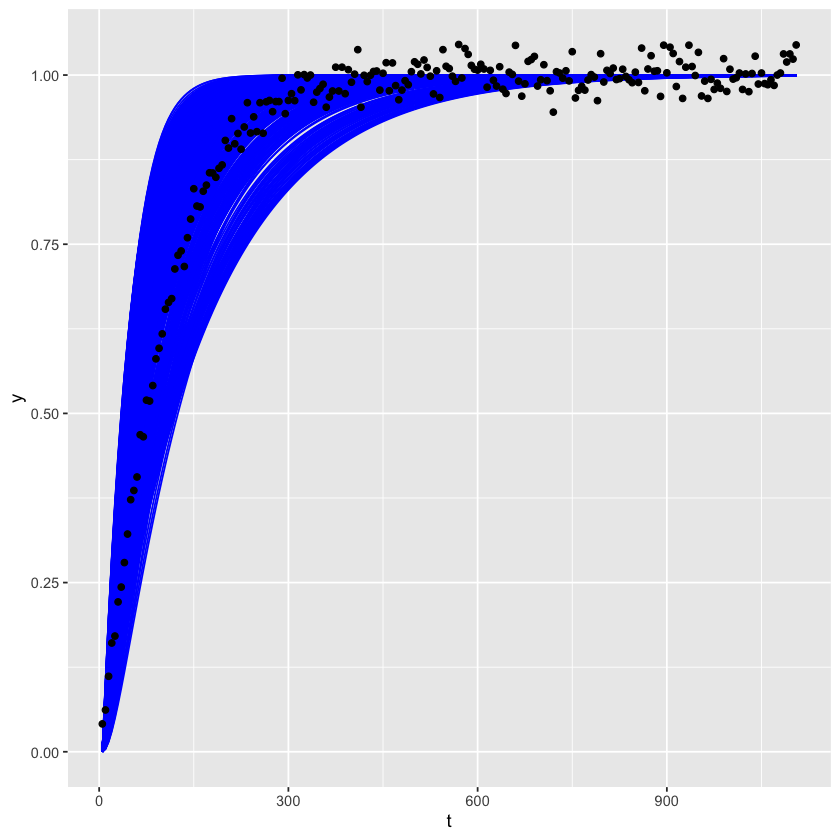

In [17]:
source(paste0(SBtabDir,"/plotFunctionsAKAR4.R"))

plotDataAndSimulations(draws, expInd=1)

The empirical distribution of parameter draws is an approximation of the posterior distribution of parameters, gived data from the first experiment.

We fit a copula based on this posterior parameter distribution, and we use it as prior parameter distribution for the following UQ, where we will consider data from the second experiment.

In [18]:
#Fitting Copula based on previous MCMC runs
out <- fitCopula(draws, ll, ul, nCores=1)        
copula <- out$copula
U <- out$U
Z <- out$Z
Y <- out$Y

#second set of experiments
expInd <- experimentsIndices[[2]]

## Run Pre-Calibration Sampling
out1 <- preCalibration(experiments[expInd], modelName, parVal, parIdx, npc, copula, U, Z, getScore, nCores = nCores, environment)
out2 <- getMCMCPar(out1$prePar, out1$preDelta, p, sfactor, delta, nChains)
Sigma <- out2$Sigma
startPar <- out2$startPar

## Run ABC-MCMC Sampling
cl <- makeForkCluster(nChains)
draws <- parLapply(cl, 1:nChains, function(k) ABCMCMC(experiments[expInd], modelName, startPar[k,], parIdx, parVal, ns, Sigma, delta, U, Z, Y, copula, ll, ul, getScore, nCores, environment))
stopCluster(cl)
                   
# put draws together (from list to matrix)
draws <- do.call("rbind", draws)
pick <- !apply(draws, 1, function(rw) all(rw==0))
draws <- draws[pick,]
               
dim(draws)
head(draws)


[1] 400   3

-1.557083,0.9399454,1.582914
-1.728016,0.3968937,1.748682
-1.546925,0.8949180,1.360561
-1.626164,0.6363046,1.421520
-1.562903,0.4069705,1.481693
-1.680938,0.4945219,1.228473


We use the draws, sampled through the ABCMCMC algorithm, to simulate trajectories.
We plot the trajectories (blue curves), together with the data from experiment 2 (black dots), using function `plotDataAndSimulations`.

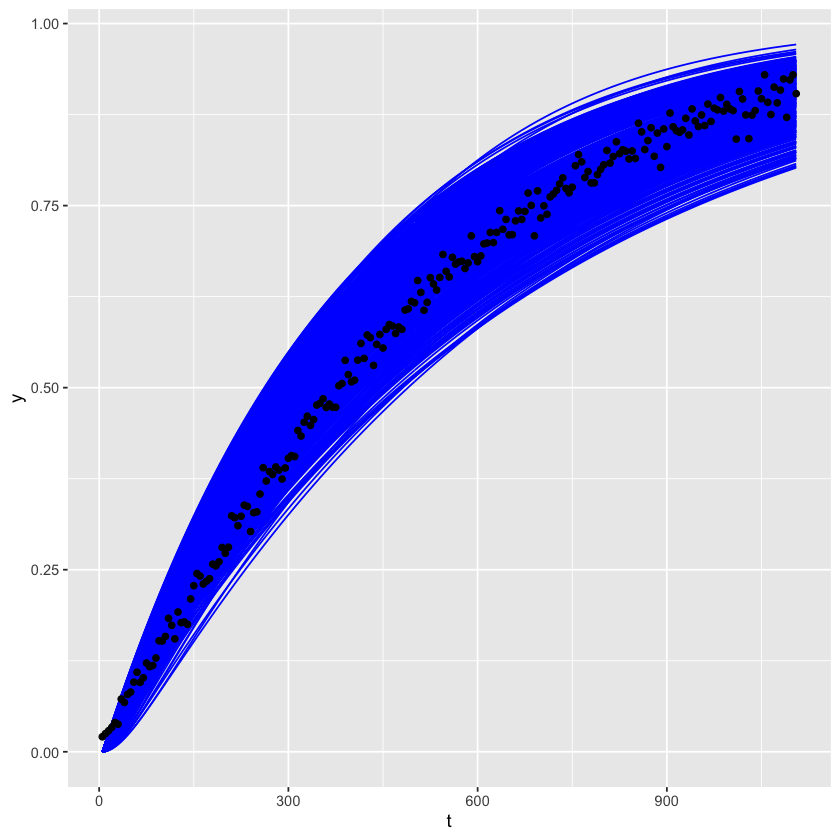

In [19]:
plotDataAndSimulations(draws, expInd=2)

The simulated time series agree with the experimental data from experiment 2.
This is reasonable, also due to the fact that we used data frmo experiment 2 in the ABCMCMC algorithm.

We now use the same draws applied to the same initial conditions as experiment 1, to see whether these parameters fit also the first experimental dataset.

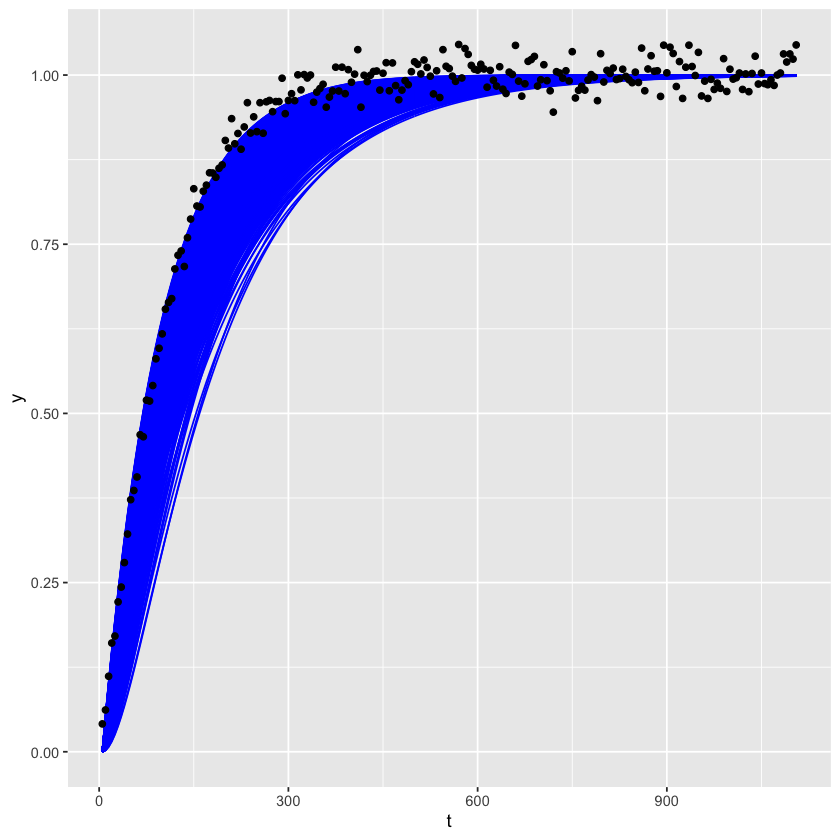

In [20]:
plotDataAndSimulations(draws, expInd=1)

Some of the draws lead to simulated time series (blue curves) that are "too far" from the first experiment data. Hence, we filter out such draws using function `checkFitWithPreviousExperiments`.

In [21]:
# Checking fit with dataset 1
draws <- checkFitWithPreviousExperiments(2, experimentsIndices, modelName, 
                                         draws, experiments, parVal, parIdx, 
                                         getScore, delta, environment, nCores, nChains)

-Checking fit with dataset 1 
--  26  samples of posterior after datasets  2  did not fit dataset  1

In [22]:
dim(draws)
head(draws)

[1] 374   3

-1.557083,0.9399454,1.582914
-1.728016,0.3968937,1.748682
-1.546925,0.8949180,1.360561
-1.626164,0.6363046,1.421520
-1.562903,0.4069705,1.481693
-1.680938,0.4945219,1.228473


We plot again the simulated time series and the data point for the first and second experiment.

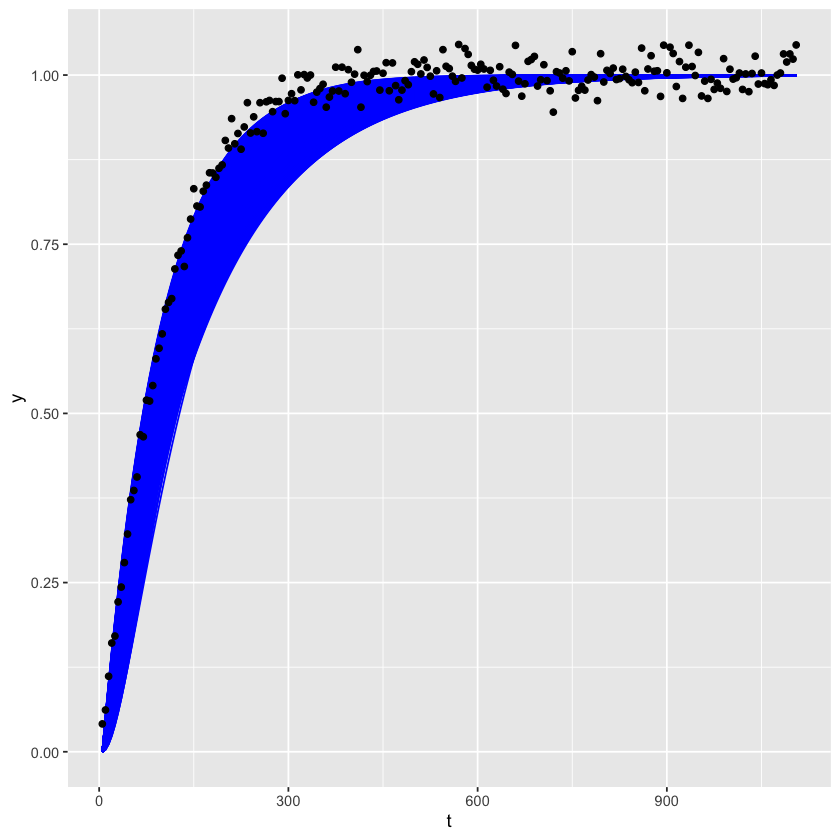

In [23]:
plotDataAndSimulations(draws, expInd=1)

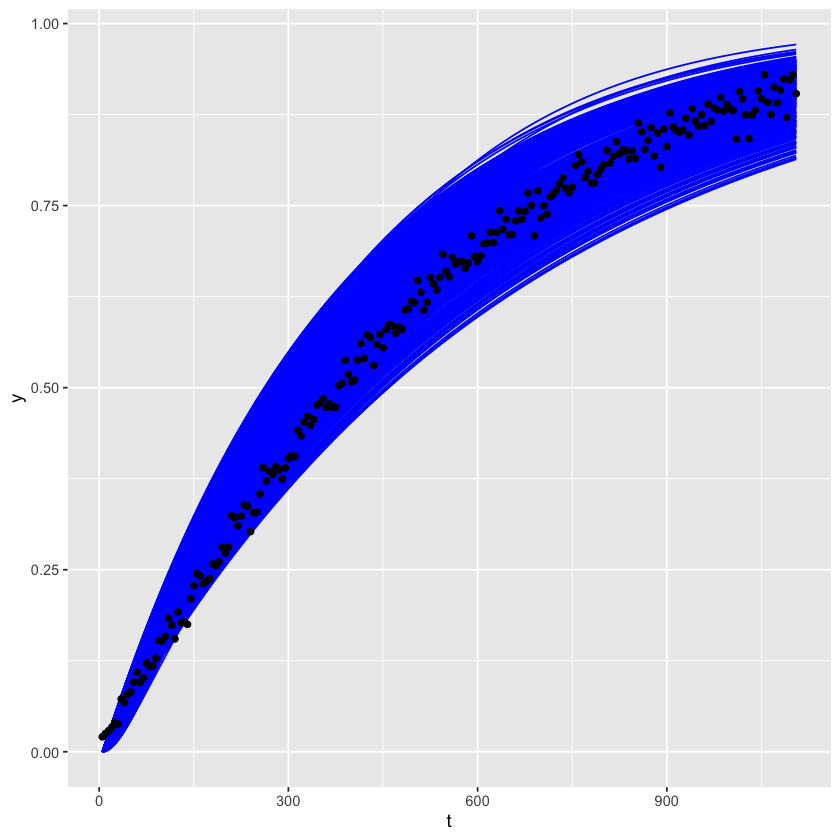

In [24]:
plotDataAndSimulations(draws, expInd=2)

We now prceed with the UQ using the third dataset, using a prior distribution given by the copula, fit with the draws from the previous step. 

In [25]:
#third set of experiments
expInd <- experimentsIndices[[3]]

#Fitting Copula based on previous MCMC runs
out <- fitCopula(draws, ll, ul, 1)        
copula <- out$copula
U <- out$U
Z <- out$Z
Y <- out$Y
  
## Run Pre-Calibration Sampling
out1 <- preCalibration(experiments[expInd], modelName, parVal, parIdx, npc, copula, U, Z, getScore, nCores = nCores, environment)
  
## Get Starting Parameters from Pre-Calibration
out2 <- getMCMCPar(out1$prePar, out1$preDelta, p, sfactor, delta, nChains)
Sigma <- out2$Sigma
startPar <- out2$startPar

## Run ABC-MCMC Sampling
cl <- makeForkCluster(nChains)
draws <- parLapply(cl, 1:nChains, function(k) ABCMCMC(experiments[expInd], modelName, startPar[k,], parIdx, parVal, ns, Sigma, delta, U, Z, Y, copula, ll, ul, getScore, nCores, environment))
stopCluster(cl)
                   
# put draws together (from list to matrix)
draws <- do.call("rbind", draws)
pick <- !apply(draws, 1, function(rw) all(rw==0))
draws <- draws[pick,]

In [26]:
dim(draws)
head(draws)

[1] 400   3

-1.777902,-2.2613372,1.0541024
-1.779159,-2.5093301,0.6700998
-1.712189,-2.0682488,0.3642392
-1.667611,-1.5436024,0.6153468
-1.711556,-0.8454774,1.4678891
-1.655133,-0.9404303,1.1727192


We plot the timeseries data in the third experiments, and the simulated timeseries where the parameters in `draws` are used.

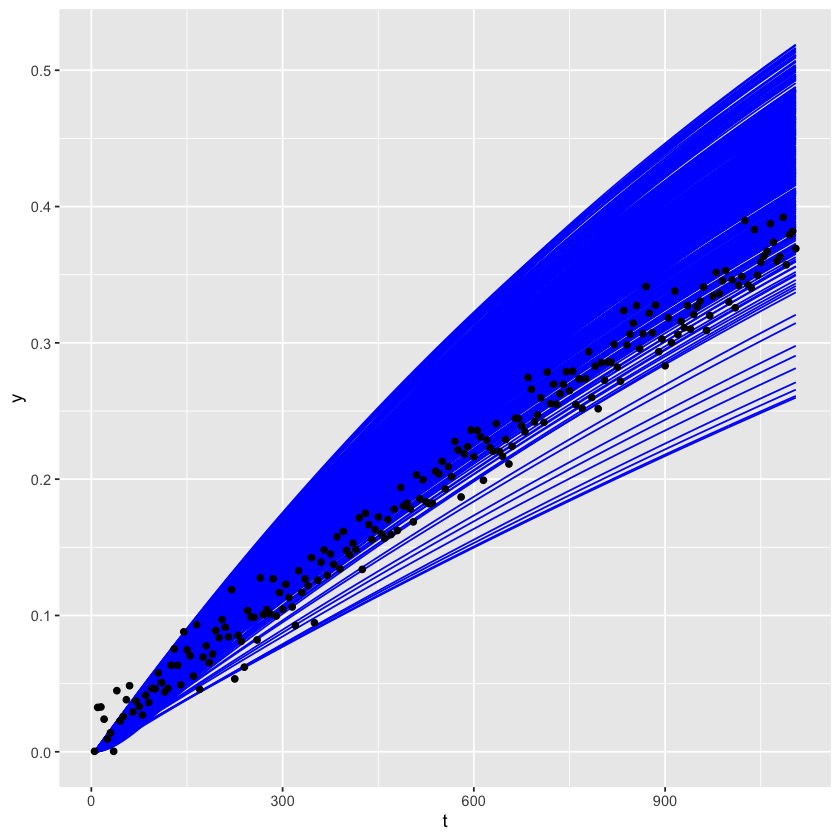

In [27]:
plotDataAndSimulations(draws, expInd=3)

We compare the experimental datapoints of experiment 1 with the simulations obtained with the parameters in `draws` and the same initial conditions as in experiment 1.

In [ ]:
plotDataAndSimulations(draws, expInd=1)

We compare the experimental datapoints of experiment 2 with the simulations obtained with the parameters in `draws` and the same initial conditions as in experiment 2.

In [ ]:
plotDataAndSimulations(draws, expInd=2)

We filter out the parameters that produce simulations that are "too far" from the data in experiment 1 and 2.

In [ ]:
# Checking fit with dataset 1
draws <- checkFitWithPreviousExperiments(3, experimentsIndices, modelName, 
                                         draws, experiments, parVal, parIdx, 
                                         getScore, delta, environment, nCores, nChains)


In [ ]:
dim(draws)
head(draws)

We plot again simulations and experimental datapoint in the 3 experimental setups.

In [ ]:
plotDataAndSimulations(draws, expInd=1)

In [ ]:
plotDataAndSimulations(draws, expInd=2)

In [ ]:
plotDataAndSimulations(draws, expInd=3)

## Plot final results 

In [ ]:
parNames <- model[["Parameter"]][["!Name"]]
# histograms 
par(mfrow=c(2,3))
for(i in 1:3){
  hist(draws[,i], main=parNames[i], xlab = "Value in log scale")
}

# scatterplot for pairs of parameters
combinePar <- list(c(1,2), c(1,3), c(2,3))
for(i in combinePar){
  plot(draws[,i[1]], draws[,i[2]], xlab = parNames[i[1]], ylab = parNames[i[2]])
}


In [ ]:
# scatter plot
suppressMessages(library(plotly))
par(mfrow=c(1,1))
df = as.data.frame(draws)
colnames(df) <- parNames
plot_ly(dat = df, x = ~kf_C_AKAR4, y = ~kb_C_AKAR4, z = ~kcat_AKARp, type="scatter3d", mode="markers", marker=list(size = 1, color = "red"))



# Additional information about the methods

## ABC-MCMC with copulas

In ABC, samples from a prior distribution (or a proposal distribution) are accepted if the experimental data are reproduced by simulations from the model within a certain margin, so that a distance measure $\rho(S(\mathbf{y}^{sim}),S(\mathbf{y}^\text{exp}))$ is smaller than some predefined cut-off $\delta$ (S is a summary statistic of the data). The accepted parameter sets $\mathbf{\theta}$ will form the approximate posterior distribution $f(\mathbf{\theta}|\rho(S(\mathbf{y}^\text{exp}),S(\mathbf{y}^{sim}))\leq\delta)$. 

We use a distance measure, or scoring function, that accounts for deviations on both the model output (y-axis) and model input (x-axis) since the experimental data may be subject to experimental error both regarding input and output.  

We couple ABC to Markov chain Monte Carlo (MCMC) to efficiently sample from the posterior distribution of the parameters of interest. The model is fitted to the datasets in sequence. In order to incorporate the information from each fit, we do the following:

* Fit the model to one datataset, producing a posterior distribution
* Fit a copula to the posterior distribution 
* Use the copula as a prior to fit the model to the next dataset

We use graphical models called R-vines to formulate copulas that are constructed in pairs in order to describe the dependencies over multiple parameters. 



### Copulas

Copulas are multivariate probability distributions which describe the dependence structure between stochastic variables. The copula is a function that connects the multivariate distribution function to the marginal ones ($F_i$) as follows.

$$
F(\mathbf{x}) = C(F_1(x_1), \ldots, F_d(x_d))
$$ 

It can be shown that the multivariate (joint) density can be represented by a number of appropriate pair-copulas times the conditional marginal densities based on a pair-copula factorization. For a distribution over three variables, we have

$$
f(x_1, x_2, x_3) = c_{1,2}(F_1(x_1),F_2(x_2))c_{2,3|1} (F(x_2|x_1), F(x_3|x_1))c_{1,3}(F_1(x_1), F_3(x_3))f_1(x_1) f_3 (x_3) f_2(x_2)\\
$$

The copula pairs can be chosen independently of each other giving a wide range of possible dependence structures. We use graphical models called R-vines to arrange the pair copulas in a tree structure. 

Let's assume we work with a simple bivariate distribution and that we have a bivariate sample $\mathbf{x}=[\mathbf{x}_1, \mathbf{x}_2]$. For each variable $X_1$ and $X_2$, we estimate a cumulative distribution $P(X_1 \leq x_1)$ and $P(X_2 \leq x_2)$ (this can be done in R using e.g. the kcde or ecdf functions). We evaluate these cumulative densities in the sample points $[\mathbf{x}_1, \mathbf{x}_2]$ and denote this information $\mathbf{z}=[\mathbf{z}_1, \mathbf{z}_2]$. This step maps the sample points ($\mathbf{x}$) into the $[0,1]$ space and we fit a copula to $\mathbf{z}$ in this space.




### Pre-calibration

Each fit to a dataset begins with a pre-calibration step, in order to construct a covariance matrix for the MCMC transition kernel as well as finding starting points for the MCMC chains.

In the pre-calibration step we sample independently from the prior distribution a number of times ($npc$) to produce a set of samples. We generate simulated output from the model for each parameter set and check, using the distance measure, how close the simulated outputs $\mathbf{y}^{sim}$are to the experimental data $\mathbf{y}^{exp}$. We save a certain fraction $p$ of the samples that have the smallest distances. With these samples, we estimate a covariance matrix that is used as transition kernel Q (scaled appropriately) for the MCMC chains. We also pick random starting points for the chains. 

In order to perform a streamlined computational pipeline, we always formulate the prior distribution of the parameters in the form of a copula. For the fit to the first dataset, when we have uniform independent priors for all parameters, we use an independece copula, where all copula pairs (i.e. pairs of parameters) are independent. 